In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mango import scheduler, Tuner

In [156]:
ds = pd.read_excel(r'RETAIL.xlsx', decimal=',')

df = pd.DataFrame(ds, columns=['date', 'sales'])

df

,date,sales
0,Янв-1967,1697
1,Фев-1967,1599
2,Мар-1967,1765
3,Апр-1967,1803
4,Май-1967,1891
...,...,...
404,Сен-2000,18901
405,Окт-2000,18856
406,Ноя-2000,17856
407,Дек-2000,17647


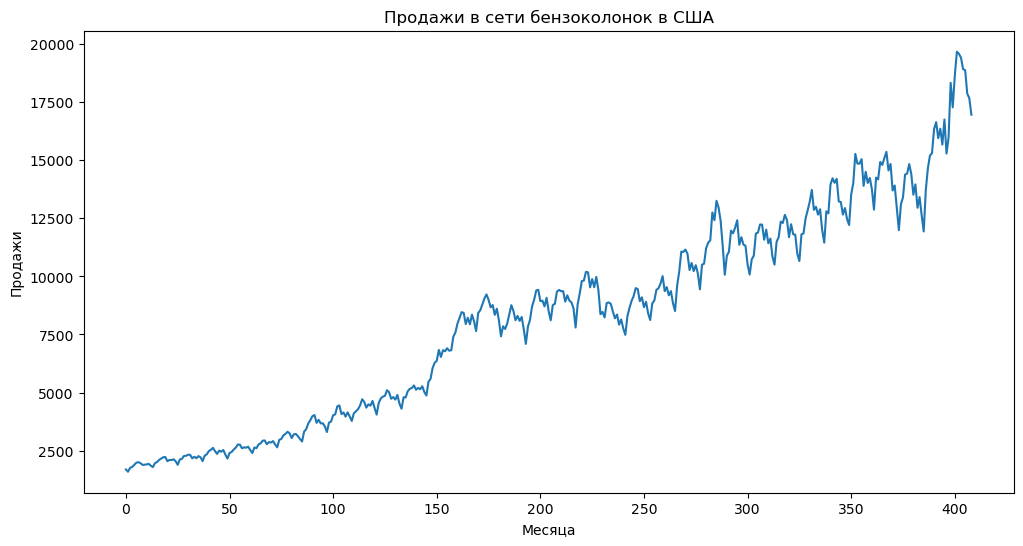

In [158]:
plt.figure(figsize=(12, 6))
plt.plot(df['sales'])
plt.title('Продажи в сети бензоколонок в США')
plt.xlabel('Месяца')
plt.ylabel('Продажи')
plt.show()

In [160]:
result = adfuller(df['sales'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: 0.7153238269202774
p-значение: 0.9901387734678273
Критические значения:
  1%: -3.4472291365835566
  5%: -2.8689795375849223
  10%: -2.5707330834976987


In [162]:
import math

df['log_sales'] = np.log(df['sales'])

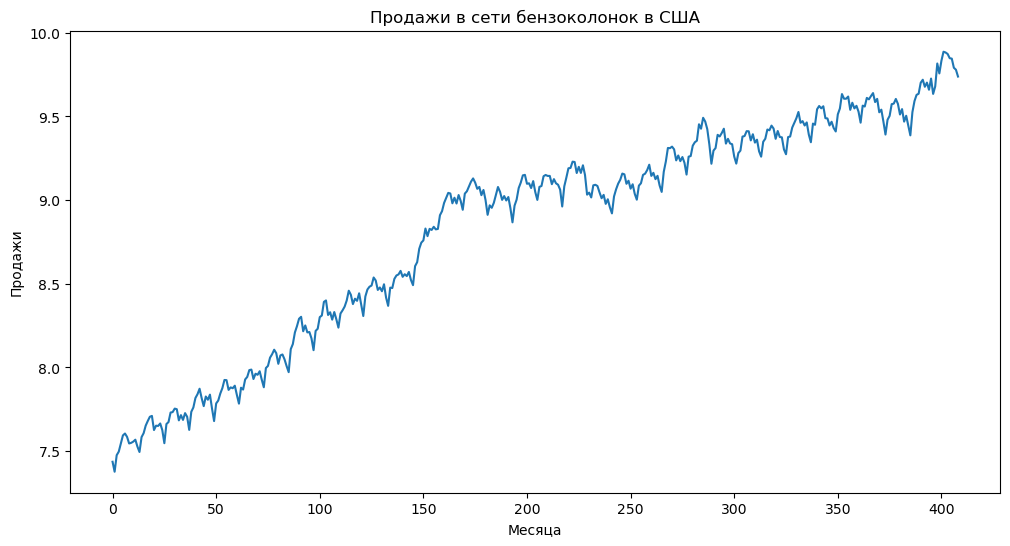

In [164]:
plt.figure(figsize=(12, 6))
plt.plot(df['log_sales'])
plt.title('Продажи в сети бензоколонок в США')
plt.xlabel('Месяца')
plt.ylabel('Продажи')
plt.show()

In [166]:
result = adfuller(df['log_sales'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -1.3063440831044626
p-значение: 0.6262649129232984
Критические значения:
  1%: -3.447014064067954
  5%: -2.8688850015516016
  10%: -2.5706826870693797


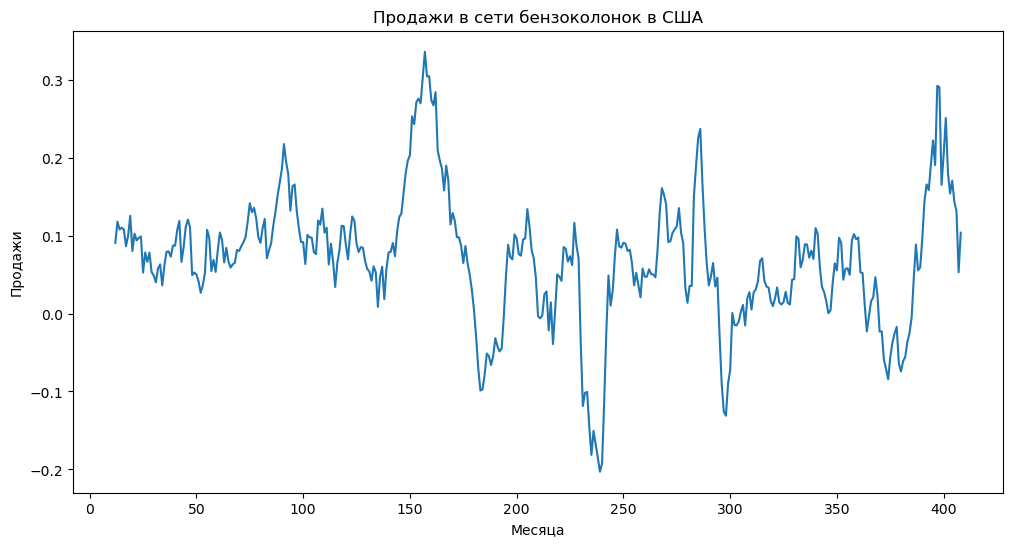

In [168]:
df['time_series_diff_1'] = df['log_sales'] - df['log_sales'].shift(12)

df.dropna(inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(df['time_series_diff_1'])
plt.title('Продажи в сети бензоколонок в США')
plt.xlabel('Месяца')
plt.ylabel('Продажи')
plt.show()

In [172]:
result = adfuller(df['time_series_diff_1'])
print('ADF статистика:', result[0])
print('p-значение:', result[1])
print('Критические значения:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF статистика: -3.1065344992401522
p-значение: 0.026073370504808745
Критические значения:
  1%: -3.4474946672686824
  5%: -2.8690962436986855
  10%: -2.570795299750434


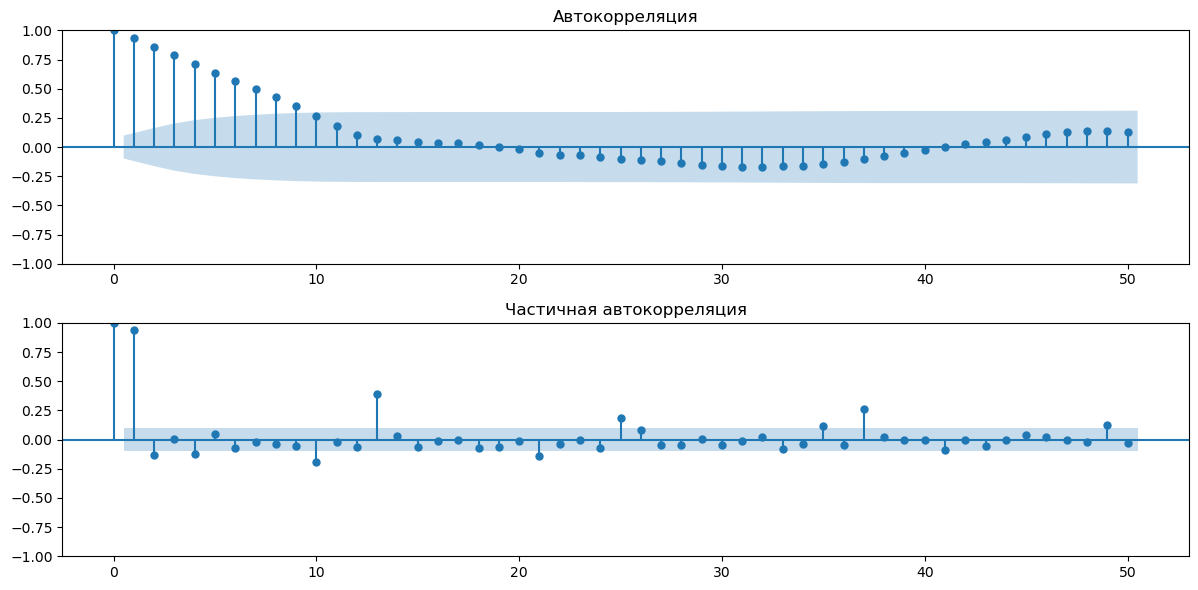

In [174]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['time_series_diff_1'], lags=50, ax=plt.gca())
plt.title('Автокорреляция')

plt.subplot(212)
plot_pacf(df['time_series_diff_1'], lags=50, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

In [178]:
p = 3
d = 1
q = 0

model = ARIMA(df['time_series_diff_1'], order=(p, d, q))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     time_series_diff_1   No. Observations:                  397
Model:                 ARIMA(3, 1, 0)   Log Likelihood                 839.428
Date:                Thu, 09 May 2024   AIC                          -1670.856
Time:                        21:19:50   BIC                          -1654.930
Sample:                             0   HQIC                         -1664.547
                                - 397                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1161      0.043      2.725      0.006       0.033       0.200
ar.L2         -0.0679      0.041     -1.645      0.100      -0.149       0.013
ar.L3          0.0888      0.047      1.904      0.0

In [9]:
# Прогноз на основе обученной модели
forecast = model_fit.forecast(steps=12)

# Рассчитываем MSE и MAE
mse = mean_squared_error(df['sales'][-12:], forecast)
mae = mean_absolute_error(df['sales'][-12:], forecast)

print(f'MSE: {mse}')
print(f'MAE: {mae}')

MSE: 333906986.21203995
MAE: 18238.46924231665


In [10]:
def arima_objective_function(args_list):
    global data_values
    
    params_evaluated = []
    results = []
    
    for params in args_list:
        try:
            p,d,q = params['p'],params['d'], params['q']
            trend = params['trend']
            
            model = ARIMA(data_values, order=(p,d,q), trend = trend)
            predictions = model.fit()
            mse = mean_squared_error(data_values, predictions.fittedvalues)   
            params_evaluated.append(params)
            results.append(mse)
        except:
            #print(f"Exception raised for {params}")
            #pass 
            params_evaluated.append(params)
            results.append(1e5)
        
        #print(params_evaluated, mse)
    return params_evaluated, results

param_space = dict(p= range(0, 30),
                   d= range(0, 1),
                   q =range(0, 30),
                   trend = ['n', 'c', 't', 'ct']
                  )

conf_Dict = dict()
conf_Dict['num_iteration'] = 200
data_values = list(df['sales'])
tuner = Tuner(param_space, arima_objective_function, conf_Dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best loss:', results['best_objective'])

  0%|          | 0/200 [00:00<?, ?it/s]

best parameters: {'d': 0, 'p': 29, 'q': 18, 'trend': 'ct'}
best loss: 82463.93890808256


{'d': 0, 'p': 29, 'q': 18, 'trend': 'ct'}
final model: (29, 0, 18) ct
MSE error is: 82463.93890808256


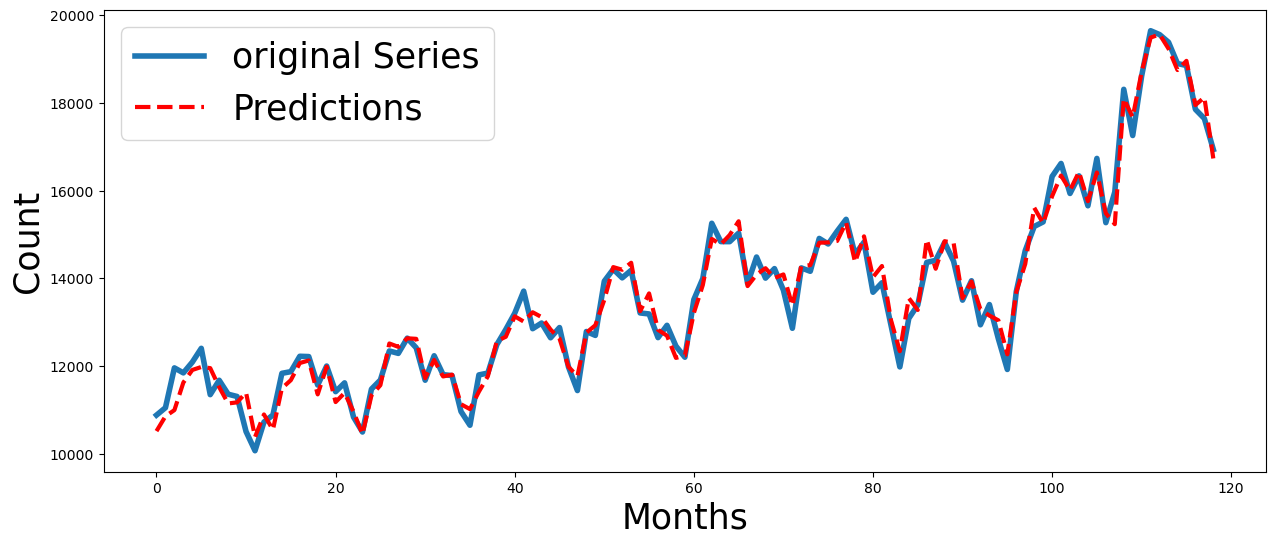

In [11]:
def plot_arima(data_values, order=(1, 1, 1), trend=None):
    print('final model:', order, trend)
    model = ARIMA(data_values, order=order, trend=trend)
    results = model.fit()
    
    error = mean_squared_error(data_values, results.fittedvalues)   
    print('MSE error is:', error)
    
    from matplotlib import pyplot as plt
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(6)
    plt.plot(data_values, label="original Series", linewidth=4)
    plt.plot(results.fittedvalues, color='red', label="Predictions", linestyle='dashed', linewidth=3)
    plt.legend(fontsize=25)
    plt.xlabel('Months', fontsize=25)
    plt.ylabel('Count', fontsize=25)
    plt.show()

print(results['best_params'])

order = (results['best_params']['p'], results['best_params']['d'], results['best_params']['q'])
plot_arima(data_values, order=order, trend = results['best_params']['trend'])